In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pickle
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
from crnn.models import crnn
from crnn.utils import load_conf

In [ ]:
conf = load_conf("./conf/crnn.yaml")

In [ ]:
conf

In [51]:
keras.backend.clear_session()
model = crnn(conf["options"], train=False, infer_shape=(64, 1024, 3))

In [52]:
model.summary()
# model.output

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 1024, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 1024, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 32, 512, 16)  432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 32, 512, 16)  64          Conv[0][0]                       
______________________________________________________________________________________________

In [53]:
model.load_weights("./ckpt/mobilev3L-64.0-myna/mobilev3L-64.0-17.ckpt")

In [ ]:
def resize_pad(img, h, w):
    w_new = int(h / img.shape[0] * img.shape[1])
    img = cv2.resize(img, (w_new, h), cv2.INTER_AREA)
    if img.shape[1] >= w: return img[:, :w], w // 16
    padded = np.zeros((h, w, 3)).astype(img.dtype)
    padded[:, :img.shape[1]] = img
    return padded, img.shape[1] // 16

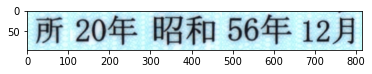

34


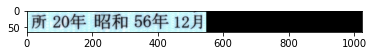

In [83]:
plt.imshow(plt.imread("./data/1.jpg"))
plt.show()
img, input_len = resize_pad(plt.imread("./data/1.jpg"), 64, 1024)
plt.imshow(img)
print(input_len)

In [55]:
with open("./id2char_std.pkl", "rb") as f:
    id2char = pickle.load(f)

In [81]:
def decode(logits):
    probs = tf.nn.softmax(logits, axis=-1)
    print(probs.shape)
    decoded = keras.backend.ctc_decode(probs, input_length=[input_len])
    print(decoded)
    text = "".join([id2char[x] for x in decoded[0][0].numpy()[0] if x != -1])
    return text

In [82]:
logits = model.predict(img[np.newaxis, ...])
# print(logits)

decode(logits)
# probs = tf.nn.softmax(logits,axis=-1)
# probs.numpy().shape


(1, 64, 7550)
([<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[131,   6,  39, 197,  60,  43,  34,  42, 197,   1,   6, 177,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]])>], <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[269.63715]], dtype=float32)>)


'所２０年昭和５６年１２月'

# Save for inference

In [ ]:
INPUT_SHAPE = (64, 1408, 3)
# INPUT_SHAPE = (64, 1024, 3)
# INPUT_SHAPE = (64, 192, 3)

keras.backend.clear_session()

conf = load_conf("./conf/crnn.yaml")
model = crnn(conf["options"], train=False, infer_shape=INPUT_SHAPE, include_softmax=True)
model.load_weights("./ckpt/mobilev3L-64.0-myna/mobilev3L-64.0-17.ckpt")

model.save(f"./saved_models/crnn{INPUT_SHAPE[1]}")

In [ ]:
# model.summary()